# Train simple vision model for phishing detection

## Imports

In [1]:
import numpy as np
import os
import pathlib
import PIL
import PIL.Image
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
dataset_dir = pathlib.Path("../phi_dataset/")
model_dir = pathlib.Path('../phi_models/')
checkpoint_dir = pathlib.Path('../phi_checkpoints/')

In [3]:
os.listdir(dataset_dir)

['phishing', 'trusted_list']

In [4]:
import datetime
date = datetime.datetime.now()
date = '_'.join(str(date).split()).replace(':', ';')
print(date)

2021-07-25_20;22;06.309418


## Params

In [5]:
model_name = "custom3"
batch_size = 16
img_height = 256
img_width = 512 

rest_split_ratio = 0.2
test_split_ratio = 0.2

## Load dataset

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_dir,
  validation_split=rest_split_ratio,
  subset="training",
  label_mode = 'binary',
  seed=132,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10541 files belonging to 2 classes.
Using 8433 files for training.


In [7]:
rest_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_dir,
  validation_split=rest_split_ratio,
  subset="validation",
  label_mode='binary',
  seed=132,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10541 files belonging to 2 classes.
Using 2108 files for validation.


In [8]:
rest_batches = rest_ds.cardinality().numpy()
print(rest_batches)

132


In [9]:
val_ds = rest_ds.skip(int(rest_batches * test_split_ratio // batch_size))
test_ds = rest_ds.take(int(rest_batches * test_split_ratio // batch_size))

In [10]:
class_names = train_ds.class_names

In [11]:
class_names

['phishing', 'trusted_list']

## Visualize data

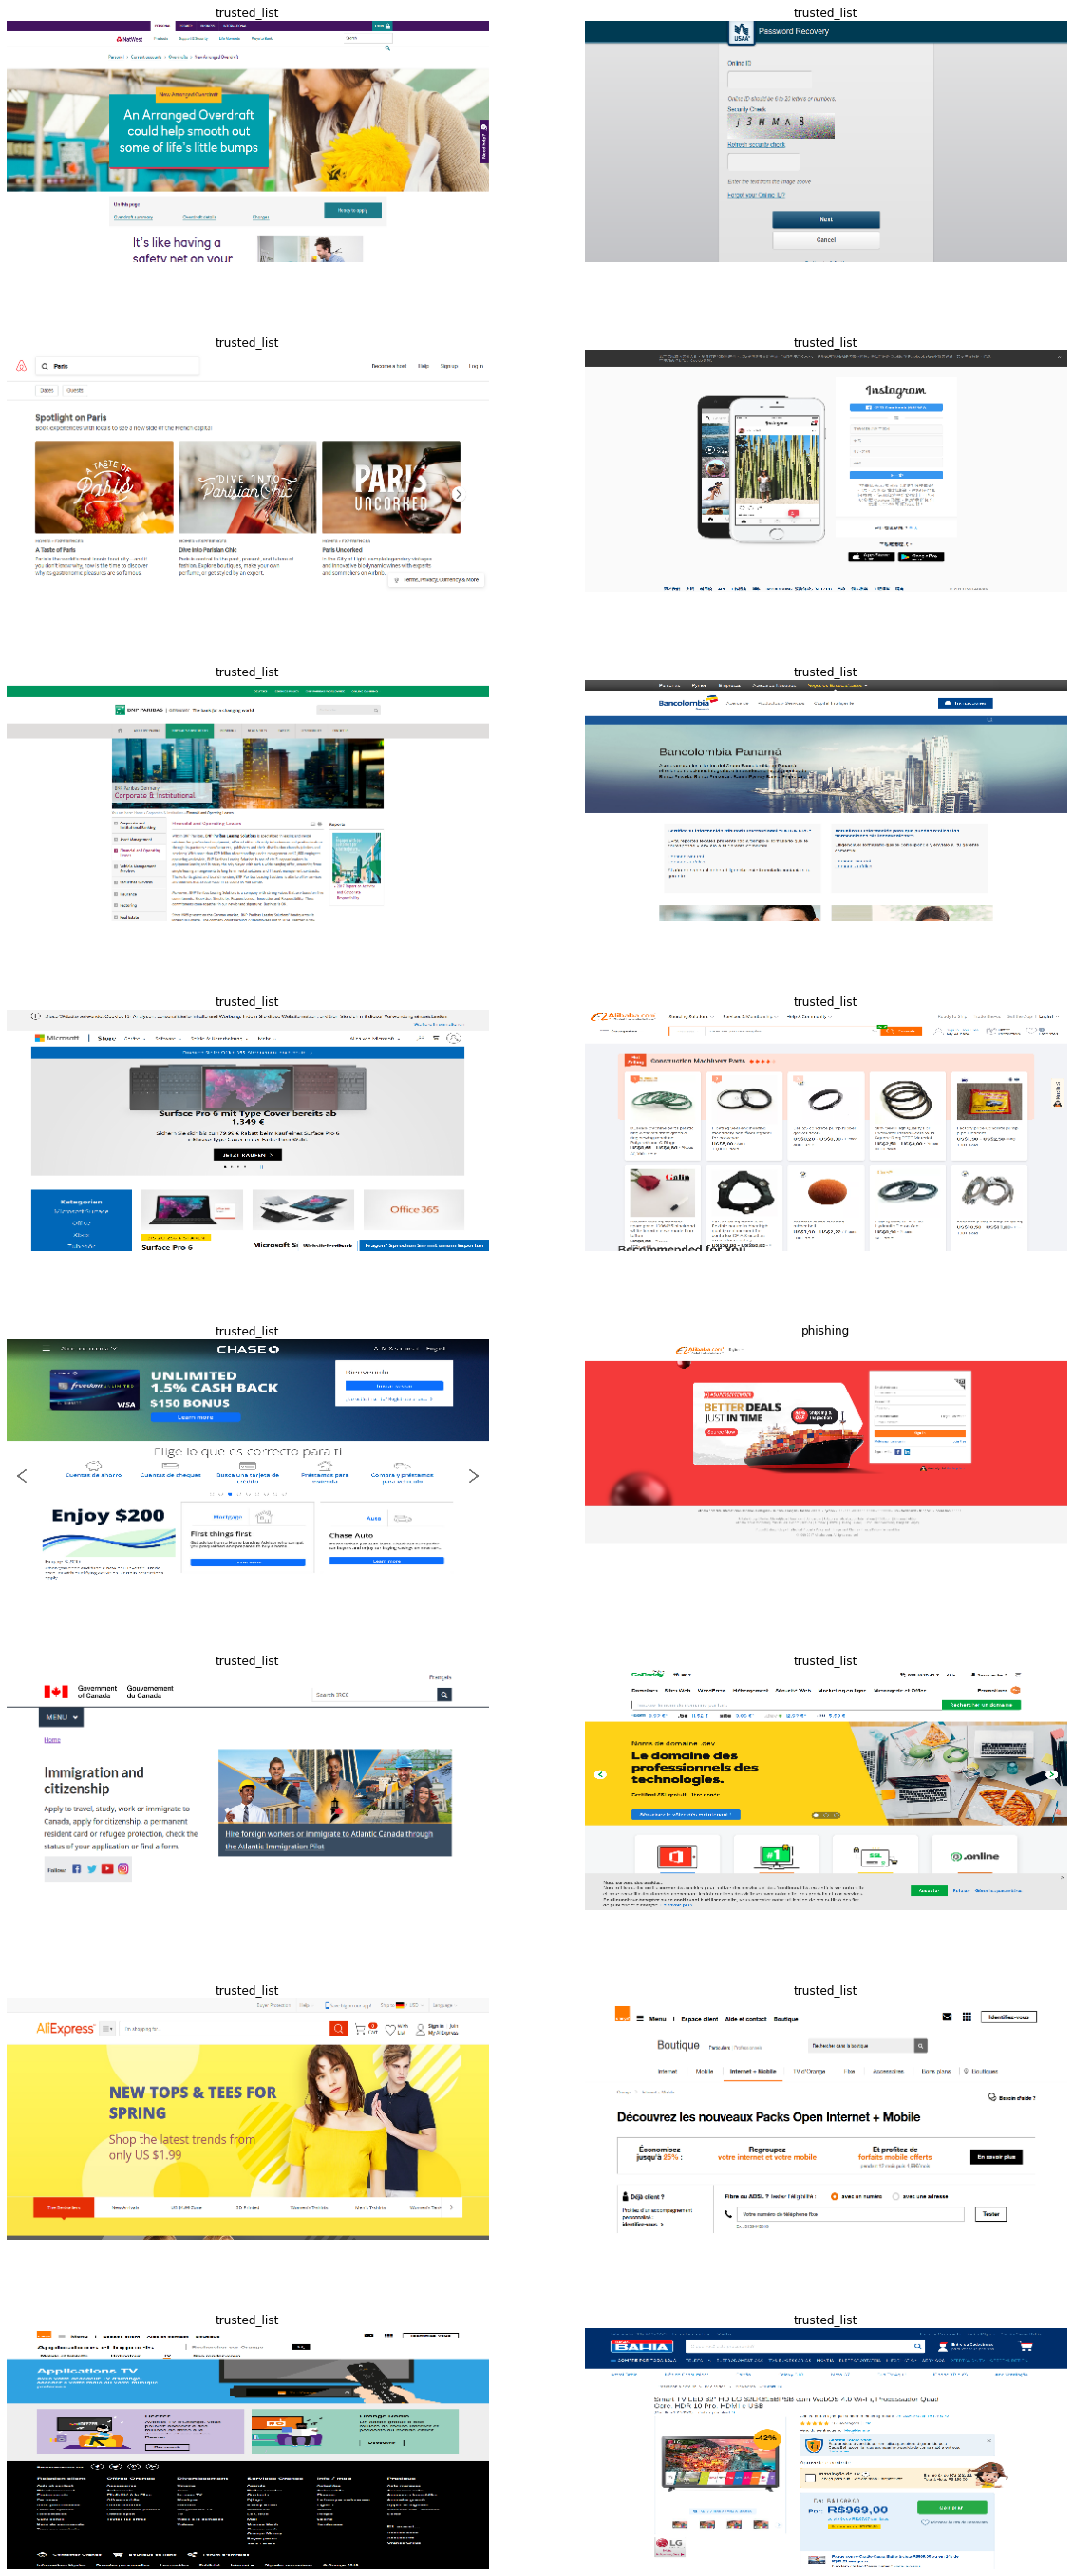

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 50))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(8, 2, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[int(labels[i])])
    plt.axis("off")

## Tune dataset

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(512).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Model

In [14]:
num_classes = 2
dropout_prob1 = 0.2
dropout_prob2 = 0.3
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(dropout_prob1),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(dropout_prob2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes-1)
])


In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [16]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 256, 512, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 512, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 256, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 256, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 128, 32)       0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 128, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 128, 64)       1

## Training

In [17]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        # The saved model name will include the current epoch.
        filepath=checkpoint_dir / f"{date}_{model_name}_valacc{{val_accuracy:.4f}}_e{{epoch}}",
        save_best_only=True,  # Only save a model if `val_loss` has improved.
        monitor="val_loss",
        verbose=1,
    ),
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-4,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=4,
        verbose=1,
    )
]


In [18]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=callbacks
)

Epoch 1/10
528/528 [==============================] - 108s 73ms/step - loss: 0.3487 - accuracy: 0.8824 - val_loss: 0.2582 - val_accuracy: 0.9034

Epoch 00001: val_loss improved from inf to 0.25818, saving model to ..\phi_checkpoints\2021-07-25_20;22;06.309418_custom3_valacc0.9034_e1
INFO:tensorflow:Assets written to: ..\phi_checkpoints\2021-07-25_20;22;06.309418_custom3_valacc0.9034_e1\assets
Epoch 2/10
528/528 [==============================] - 43s 81ms/step - loss: 0.2320 - accuracy: 0.9044 - val_loss: 0.2682 - val_accuracy: 0.8800

Epoch 00002: val_loss did not improve from 0.25818
Epoch 3/10
528/528 [==============================] - 27s 51ms/step - loss: 0.1766 - accuracy: 0.9315 - val_loss: 0.2243 - val_accuracy: 0.9039

Epoch 00003: val_loss improved from 0.25818 to 0.22431, saving model to ..\phi_checkpoints\2021-07-25_20;22;06.309418_custom3_valacc0.9039_e3
INFO:tensorflow:Assets written to: ..\phi_checkpoints\2021-07-25_20;22;06.309418_custom3_valacc0.9039_e3\assets
Epoch 4/1

## Save model

In [19]:
val_acc = history.history['val_accuracy']
model.save(model_dir / f"{date}_{model_name}_valacc{val_acc[-1]:0.4f}_e{len(val_acc)}_b{batch_size}.tf",
           include_optimizer=True)

INFO:tensorflow:Assets written to: ..\phi_models\2021-07-25_20;22;06.309418_custom3_valacc0.9350_e8_b16.tf\assets


## Load model

In [20]:
# change filename to the model you want to load
model_filename = "2021-07-25_20;02;47.486622_custom1_valacc0.9135_e4_b16.tf"
model2 = keras.models.load_model(
    model_dir / model_filename,
    compile=True)

## Visulaize loss and acc

In [21]:
history.history

{'loss': [0.3487462103366852,
  0.23200201988220215,
  0.17660939693450928,
  0.13061797618865967,
  0.09158165007829666,
  0.0656612440943718,
  0.04603765159845352,
  0.03551701083779335],
 'accuracy': [0.8823668956756592,
  0.9044231176376343,
  0.9314597249031067,
  0.9565990567207336,
  0.9774694442749023,
  0.9900391101837158,
  0.9966797232627869,
  0.9969168901443481],
 'val_loss': [0.25817862153053284,
  0.2682130038738251,
  0.22431091964244843,
  0.20789434015750885,
  0.21461567282676697,
  0.2109857201576233,
  0.32972797751426697,
  0.2536032497882843],
 'val_accuracy': [0.9034416675567627,
  0.8800191283226013,
  0.9039196968078613,
  0.9130018949508667,
  0.9292542934417725,
  0.9311663508415222,
  0.9364244937896729,
  0.9349904656410217]}

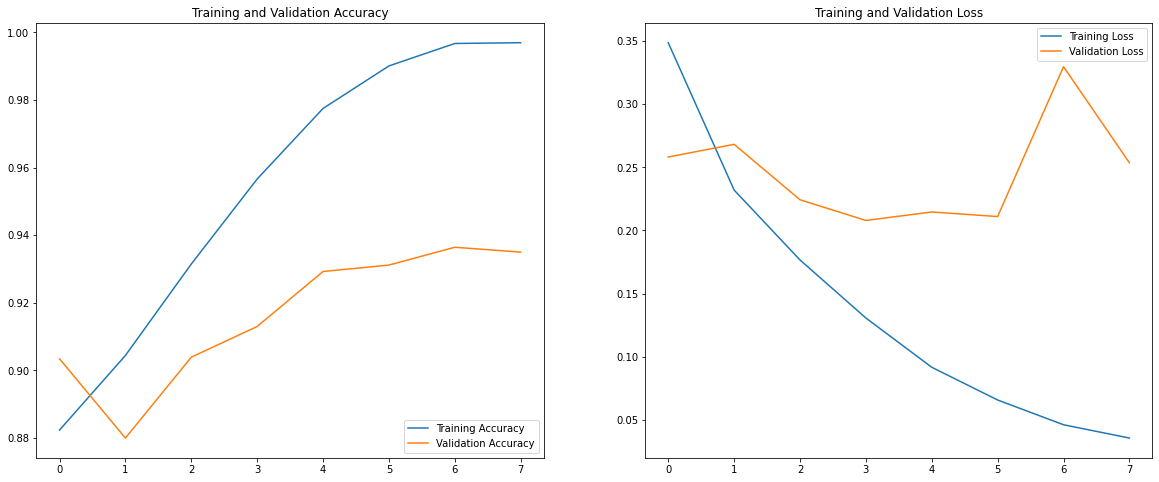

In [22]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# epochs_range = range(epochs)
epochs_range = history.epoch

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


## Evaluate (test)

In [23]:
val_results = model.evaluate(val_ds, batch_size=256)
print("val loss, val acc:", val_results)

131/131 [==============================] - 2s 11ms/step - loss: 0.2536 - accuracy: 0.9350
val loss, val acc: [0.2536032497882843, 0.9349904656410217]


In [24]:
results = model.evaluate(test_ds, batch_size=32)
print("test loss, test acc:", results)


1/1 [==============================] - 1s 1s/step - loss: 0.1745 - accuracy: 0.9375
test loss, test acc: [0.17453108727931976, 0.9375]
